## Problem 1 - Kernel Ridge Regression

In [1]:
#!pip3 install -U scikit-learn scipy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import mean_squared_error as MSE
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Question 1a

One common application of kernels is in regression. While regression can take lots of computation, using kernelization allows you to speed up the process by reusing the computed kernel. Let's observe a few examples, and learn how to implement regression with kernelization. 


In [4]:
### Utility functions

#kernel
def generate_kernel_widget():
    return widgets.Dropdown(
        options=['rbf', 'laplacian'],
        description='kernel: ',
        disabled=False)

#parameter of the kernel
def generate_gamma_widget():
    return widgets.FloatLogSlider(
        value=-50,
        base=np.sqrt(2),
        min=-20,
        max=40, 
        step=1,
        description='$\gamma$',
        continuous_update= False)

#level of regularization
def generate_reg_widget():
    return widgets.FloatLogSlider(
        value=0.,
        base=np.sqrt(2),
        min=-100,
        max=40, 
        step=1,
        description='Reg ($\lambda$):',
        continuous_update= False)

# Ground truth function
def generate_function_widget():
    return widgets.Dropdown(
        value='sin(20x)',
        options=['sin(20x)', 
                 'piecewise linear'],
        description='True function: ',
        disabled=False)

In [5]:
def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX))

def compute_predictor(X, y,  lambda_reg, kernel, gamma):
        """
    Input:
        X: data matrix
        y: outputs
        lambda_reg: regularization term in kernel ridge regression
        kernel: which kernel to use ['poly', 'rbf', 'laplacian']
        gamma: kernel parameter

    Output:
        predictor: predict using the kernel ridge model
        dual_coef: representation of weight vector(s) in kernel space, i.e. alpha
    """

        K = pairwise_kernels(X, X, metric=kernel, gamma=gamma)  + lambda_reg * np.eye(len(y))
        alpha = np.linalg.inv(K) @ y
        return lambda x: pairwise_kernels(x, X, metric=kernel, gamma=gamma)  @ alpha, alpha

def plot_kernel_ridge_regression(kernel, n_samples, gamma, sigma, f_type, lambda_reg):
    n_features = 1
    rng = np.random.RandomState(1)

    X = np.sort(rng.rand(n_samples, n_features), axis=0)
    
    # Generate y
    y = f_true(X, f_type) + rng.randn(n_samples) * sigma

    # Kernel Ridge Regression Solver
    predictor, alpha_ = compute_predictor(X, y, lambda_reg, kernel=kernel, gamma=gamma)
    
    clip_bound = 2.5
    # Sample test data points
    X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
    X_test = np.sort(X_test, axis=0)

    # Visualization
    plt.figure(figsize=(10,7))
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.plot(X_test, predictor(X_test), '-', color='forestgreen',  label='prediction')
    plt.scatter(X[:,0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, f_true(X_test, f_type), '--', color='royalblue', linewidth=2.0, label='Ground truth')
    plt.legend()

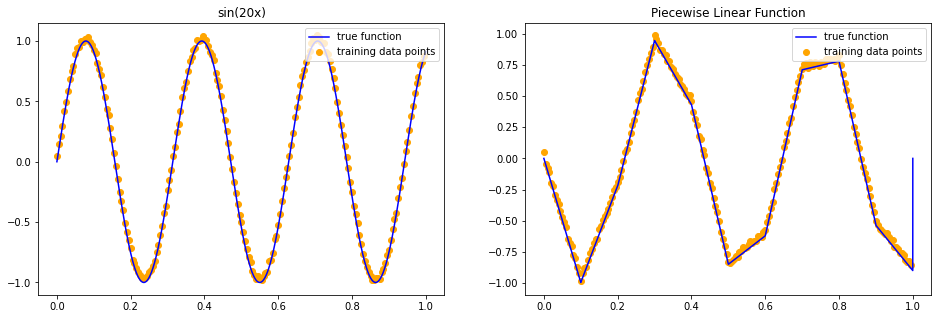

In [6]:
# Uncomment the seeded random state if you wish to get the same result every time
#rng = np.random.RandomState(0)
rng = np.random.RandomState()

# Generate sample data
n_samples = 10000
sigma = 0.05 # Standard deviation of noise
X = np.expand_dims(np.linspace(0, 1, n_samples), axis=1)
y_sin_true = f_true(X, 'sin(20x)')
y_plf_true = f_true(X, 'piecewise linear')
y_sin_noisy = (y_sin_true + rng.rand(n_samples) * sigma)[::50]
y_plf_noisy = (y_plf_true + rng.rand(n_samples) * sigma)[::50]

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(X, y_sin_true, c='b', label='true function')
plt.scatter(X[::50], y_sin_noisy, c='orange', label='training data points')
plt.title('sin(20x)');
plt.legend(loc='upper right');
plt.subplot(122)
plt.plot(X, y_plf_true, c='b', label='true function')
plt.scatter(X[::50], y_plf_noisy, c='orange', label='training data points')
plt.title('Piecewise Linear Function');
plt.legend(loc='upper right');

We'll be using the two following kernel functions: 

- Laplacian:

  $$K_{\text{rbf}}(x_i, x_j) = \exp(-\gamma(x_i - x_j)^2),$$

- RBF (radial basis function):

  $$K_{\text{laplacian}}(x_i, x_j) = \exp(-\gamma|x_i-x_j|).$$

Note: Depending on where you look, the parametrization of the kernel functions may be slightly different (by a constant factor, a reciprocal, etc.).

Let's visualize the different predictions of the function when we use different parameters.

In [7]:
interactive_plot = interactive(plot_kernel_ridge_regression,
                               n_samples=fixed(50),
                               kernel=generate_kernel_widget(),
                               gamma=generate_gamma_widget(),
                               sigma=fixed(0),
                               f_type = generate_function_widget(),
                               lambda_reg=generate_reg_widget())
interactive_plot

interactive(children=(Dropdown(description='kernel: ', options=('rbf', 'laplacian'), value='rbf'), FloatLogSli…

Answer the following questions:
- **What happens as you vary the parameters?**
- **What pair of values for the parameters work best for each combination of kernelization and true function?**
- **Does one kernel perform better than the other?**

###ANSWER HERE###
As we vary $\lambda$, we control the amount of regularization. As $\lambda$ increases, our model will become closer and closer to the constant line 0. When we increase $\gamma$, the model will begin fitting the true function. However, if we increase it too far, the model will become similar to the constant zero function except at the training data points, where the predicted function will spike to the value of the training point.

For $\sin(20x)$, $\gamma=0.0110, \lambda = 3e-8$ works well for the Laplacian kernel, and $\gamma=128, \lambda = 3e-8$ with the RBF kernel seems to fit the function exactly.

For the piecewise linear function, $\gamma=4, \lambda = 3e-8$ works well for the Laplacian kernel, and $\gamma=64, \lambda = 1.73e-4$ works well for the RBF kernel.

The RBF kernel seems to perform better than the Laplacian when trying to predict either function. We'll see that this is actually the case in the next part.

### Question 1b

Now, let's see what parameters perform best for each kernelization, and ultimately, which kernelization works better.

We will do this via grid searching a set of parameters.

__Hint__:
- Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html).

Best parameters for RBF kernel: {'alpha': 0.0001, 'gamma': 100.0}
	with Mean Square Error = 0.0007282083886586663
Best parameters for Laplacian kernel: {'alpha': 0.0001, 'gamma': 100.0}
	with Mean Square Error = 0.0009177338527023512


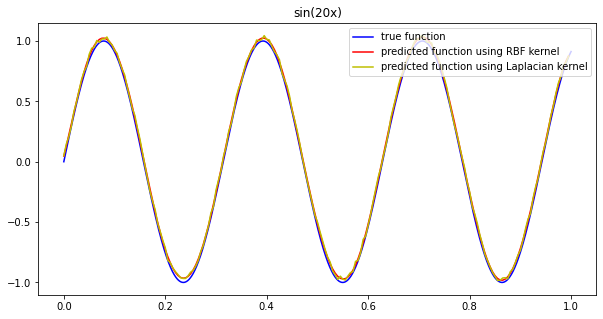

In [8]:
X_train = X[::50]
y_sin_train = y_sin_noisy

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
gammas = np.logspace(-2, 2, 5)

### BEGIN 5Bi ###

# Grid search the parameters above using kernel ridge regression
kr_rbf = GridSearchCV(KernelRidge(kernel='rbf'),
                      param_grid={"alpha": alphas,
                              "gamma": gammas})
kr_lap = GridSearchCV(KernelRidge(kernel='laplacian'),
                      param_grid={"alpha": alphas,
                              "gamma": gammas})

# Fit the data
kr_rbf.fit(X_train, y_sin_train)
kr_lap.fit(X_train, y_sin_train)

# Generate predictions from models
y_rbf_pred = kr_rbf.predict(X_train)
y_lap_pred = kr_lap.predict(X_train)

### END 5Bi ###

# Print best parameters and corresponding errors
print(f"Best parameters for RBF kernel: {kr_rbf.best_params_}")
print(f"\twith Mean Square Error = {MSE(y_sin_true[::50], y_rbf_pred)}")
print(f"Best parameters for Laplacian kernel: {kr_lap.best_params_}")
print(f"\twith Mean Square Error = {MSE(y_sin_true[::50], y_lap_pred)}")

plt.figure(figsize=(10, 5))
plt.plot(X, y_sin_true, c='b', label='true function')
# plt.scatter(X_train, y_sin_train, c='orange', label='training data points')
plt.plot(X_train, y_rbf_pred, c='r', label='predicted function using RBF kernel')
plt.plot(X_train, y_lap_pred, c='y', label='predicted function using Laplacian kernel')
plt.title('sin(20x)');
plt.legend(loc='upper right');

Best parameters for RBF kernel: {'alpha': 0.001, 'gamma': 100.0}
	with Mean Square Error = 0.7179301327921034
Best parameters for Laplacian kernel: {'alpha': 0.0001, 'gamma': 10.0}
	with Mean Square Error = 0.7188023208187144


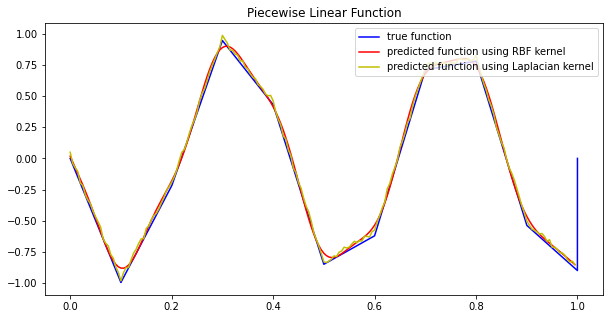

In [9]:
X_train = X[::50]
y_plf_train = y_plf_noisy

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
gammas = np.logspace(-2, 2, 5)

### BEGIN 5Bii ###

# Fit the data
kr_rbf.fit(X_train, y_plf_train)
kr_lap.fit(X_train, y_plf_train)

# Generate predictions from models
y_rbf_pred = kr_rbf.predict(X_train)
y_lap_pred = kr_lap.predict(X_train)

### END 5Bii ###

# Print best parameters and corresponding errors
print(f"Best parameters for RBF kernel: {kr_rbf.best_params_}")
print(f"\twith Mean Square Error = {MSE(y_sin_true[::50], y_rbf_pred)}")
print(f"Best parameters for Laplacian kernel: {kr_lap.best_params_}")
print(f"\twith Mean Square Error = {MSE(y_sin_true[::50], y_lap_pred)}")

plt.figure(figsize=(10, 5))
plt.plot(X, y_plf_true, c='b', label='true function')
# plt.scatter(X_train, y_sin_train, c='orange', label='training data points')
plt.plot(X_train, y_rbf_pred, c='r', label='predicted function using RBF kernel')
plt.plot(X_train, y_lap_pred, c='y', label='predicted function using Laplacian kernel')
plt.title('Piecewise Linear Function');
plt.legend(loc='upper right');

**Which kernel actually performs better? Will this always be the case?**

###ANSWER HERE###

Looking at both the sinusoidal and piecewise linear functions, the models using the RBF kernel have a lower MSE, and thus, perform better than the Laplacian kernel. That being saaid, it is not always the case that the RBF kernel outperforms the Laplacian kernel. When applying kernel ridge regression, try out different kernel functions to see which performs best!

### Question 1c

In the real world, models are often not so simple. It is rare that we find ourselves dealing with the 1d case; in fact, we will usually be dealing with models of high dimension that we are incapable of visualizing. To introduce you to higher dimension kernel ridge regression, we will consider the following 3d function:

$$f(x, y) = \sin(\sqrt{x^2 + y^2}).$$

Let's take a look at what the function we're trying to learn looks like.

Note: This has been set up so that you can try arbitrary 3d functions by changing the function passed in.

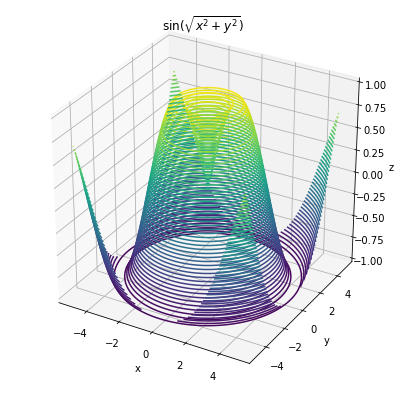

In [10]:
def gen_labels(f, *args, noisy=False):
  assert len(args) == 2, "Currently only supports 3d functions"
  rng = np.random.RandomState(1)

  data = np.meshgrid(*args)
  Z = f(*data)

  # Add noise to labels
  if noisy:
    Z += rng.rand(*Z.shape)

  return data, Z

n_samples = 1000
x = np.linspace(-5, 5, n_samples)
y = np.linspace(-5, 5, n_samples)
data, Z_true = gen_labels(lambda x, y: np.sin(np.sqrt(x**2 + y**2)), x, y)

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.contour3D(*data, Z_true, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('$\sin(\sqrt{x^2 + y^2})$');

Create a kernel ridge regression model using the RBF kernel, and use cross validation to find the best parameters. This will not be too different from learning the 1d functions. What you will see that performing kernel ridge regression is quite algorithmic. Feel free to try out other kernels as well.

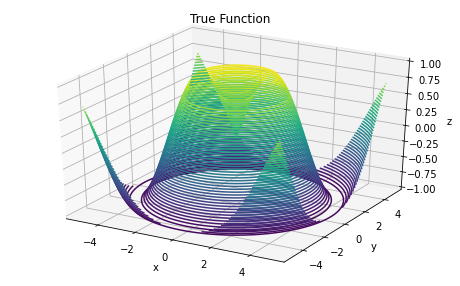

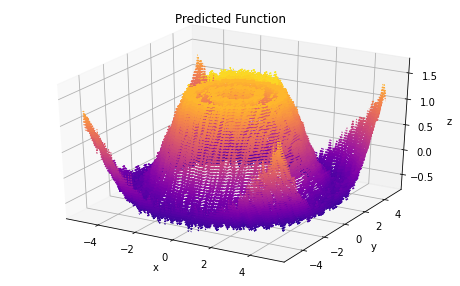

In [11]:
n_samples = 400
x_train = np.linspace(-5, 5, n_samples)
y_train = np.linspace(-5, 5, n_samples)
_, Z_train = gen_labels(lambda x, y: np.sin(np.sqrt(x**2 + y**2)), x_train, y_train, noisy=True);
X_train, Y_train = _

### START 5C ###

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
gammas = np.logspace(-2, 2, 5)

# Create the model
kr = GridSearchCV(KernelRidge(kernel='rbf'),
                      param_grid={"alpha": alphas,
                              "gamma": gammas})

train_stacked = np.hstack((X_train, Y_train))

# Fit the data
kr.fit(train_stacked, Z_train)

# Make predictions with the fitted model
Z_pred = kr.predict(train_stacked)

### END 5C ###

fig = plt.figure(figsize=(8, 5))
ax1 = plt.axes(projection='3d')
ax1.contour3D(*data, Z_true, 50)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function');
fig = plt.figure(figsize=(8, 5))
ax2 = plt.axes(projection='3d')
ax2.contour3D(X_train, Y_train, Z_pred, 50, cmap='plasma', label='predicted function')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Predicted Function');

You've succesfully performed kernel ridge regression on a 3d function! We hope that you can see that performing kernel ridge regression is not difficult and becomes formulaic once you've done it a few times.